### Import libraries

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from nltk.tokenize import word_tokenize
from collections import Counter
from nltk import PorterStemmer
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import naive_bayes, svm

#warnings.filterwarnings("ignore")
#nltk.download('stopwords')

### Read data

In [50]:
raw_df = pd.read_csv('data/amazon_data.csv')
df = raw_df[['Text', 'Score']]

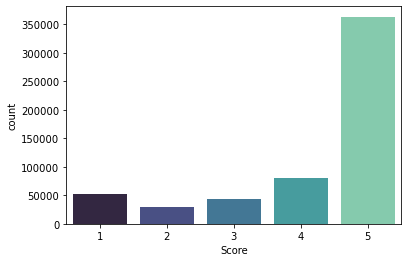

In [51]:
sns.countplot(x=df['Score'], palette='mako')
plt.show()

In [52]:
df['Score'].value_counts()

5    363122
4     80655
1     52268
3     42640
2     29769
Name: Score, dtype: int64

### Adapt and Balance target variable

In [53]:
df['Score'] = df['Score'].replace({1:-1, 2: -1, 3: -1, 4: 1, 5: 1})

C:\Users\alexx\AppData\Local\Temp/ipykernel_17704/1358285512.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Score'] = df['Score'].replace({1:-1, 2: -1, 3: -1, 4: 1, 5: 1})


In [54]:
sample_size = 10000

df_B = df[df['Score'] == -1].sample(n=sample_size, random_state=101)
df_G = df[df['Score'] == 1].sample(n=sample_size, random_state=101)

df = pd.concat([df_B, df_G]).reset_index()

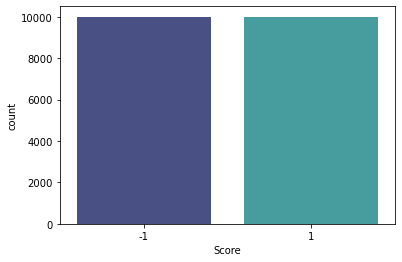

In [55]:
sns.countplot(x=df['Score'], palette='mako')
plt.show()

### Preprocessing

In [56]:
%%time
processed_df = df.copy()

# Remove page breaks
processed_df['Text'] = processed_df['Text'].str.replace(r'br', ' ', regex=True)

# Replace URLs with 'webaddress'
processed_df['Text'] = processed_df['Text'].str.replace(r'http\S+', 'webaddress', regex=True)

# Remove punctuation
processed_df['Text'] = processed_df['Text'].str.replace(r'[^\w\d\s]', ' ', regex=True)
processed_df['Text'] = processed_df['Text'].str.replace(r'_', ' ', regex=True)

# Replace numbers with 'numbr'
processed_df['Text'] = processed_df['Text'].str.replace(r'\d+(\.\d+)?', ' ', regex=True)

# Replace whitespace between terms with a single space
processed_df['Text'] = processed_df['Text'].str.replace(r'\s+', ' ', regex=True)

# Remove leading and trailing whitespace
processed_df['Text'] = processed_df['Text'].str.replace(r'^\s+|\s+?$', '', regex=True)

#All words to lowercase
processed_df['Text'] = processed_df['Text'].str.lower()

# remove stop words from text messages
stop_words = set(stopwords.words('english'))
processed_df['Text'] = processed_df['Text'].apply(lambda x: ' '.join(term for term in x.split() if term not in stop_words))

# Remove word stems using a Porter stemmer
ps = PorterStemmer()
processed_df['Text'] = processed_df['Text'].apply(lambda x: ' '.join(ps.stem(term) for term in x.split()))

Wall time: 13.3 s


### Create dataset

In [57]:
# Taken from http://web.stanford.edu/class/cs221/ Assignment #2 Support Code
def dotProduct(d1, d2):
    """
    @param dict d1: a feature vector represented by a mapping from a feature (string) to a weight (float).
    @param dict d2: same as d1
    @return float: the dot product between d1 and d2
    """
    if len(d1) < len(d2):
        return dotProduct(d2, d1)
    else:
        return sum(d1.get(f, 0) * v for f, v in d2.items())

In [58]:
def increment(d1, scale, d2):
    """
    Implements d1 += scale * d2 for sparse vectors.
    @param dict d1: the feature vector which is mutated.
    @param float scale
    @param dict d2: a feature vector.

    NOTE: This function does not return anything, but rather
    increments d1 in place. We do this because it is much faster to
    change elements of d1 in place than to build a new dictionary and
    return it.
    """
    for f, v in d2.items():
        d1[f] = d1.get(f, 0) + v * scale

In [71]:
def classification_error(X, y, w):

    count = 0
    for idx in range(len(X)):
        pred = dotProduct(w, X[idx])
    
        if pred * y[idx] < 0:
            count += 1
    return round(count/len(X),3)

In [68]:
dict_text = {}
for idx in range(len(processed_df['Text'])):
    dict_text[idx] = Counter(processed_df.loc[idx, 'Text'].split())

In [69]:
def optimized_pegasos(X_train, y_train, epochs = 3, lbd=0.01):
         
    s, t, w = 1, 1, {}
    for _ in range(epochs):
        for idx in range(0, len(X_train)):
            t += 1
            step = 1/(t*lbd)
            s *= (1-step*lbd) #Update s regardless of the training point

            if y_train[idx] * dotProduct(w, X_train[idx]) * s < 1:
                increment(w, (1/s) * step * y_train[idx], X_train[idx])
    for key, value in w.items():
        w[key] = value * s
            
    return w

In [75]:
%%time
w = optimized_pegasos(dict_text, processed_df['Score'], epochs=50, lbd=0.1)

Wall time: 38.1 s


In [76]:
classification_error(dict_text, processed_df['Score'], w)

0.213

### Model

In [134]:
X_train, X_test, y_train, y_test = train_test_split(reviews_transformed, processed_df['Score'], test_size=0.2, random_state=456)

In [135]:
%%time
log_reg = LogisticRegression(max_iter=400).fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
score = accuracy_score(y_test,y_pred)

print('Accuracy: {}%'.format(round(score*100,2)))

Accuracy: 65.23%
Wall time: 4.81 s


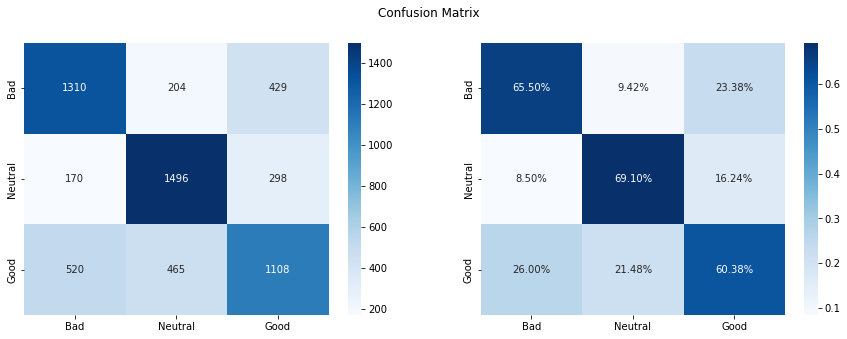

In [136]:
confusion = confusion_matrix(y_test, y_pred)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Confusion Matrix')
categories = ['Bad', 'Neutral', 'Good']
sns.heatmap(ax=axes[0], data=confusion, annot=True, fmt='g', cmap='Blues', xticklabels=categories, yticklabels=categories)
sns.heatmap(ax=axes[1], data=confusion/np.sum(confusion, axis=0), annot=True, fmt='.2%', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.show()

In [46]:
%%time
# fit the training dataset on the NB classifier
Naive = naive_bayes.MultinomialNB()
Naive.fit(X_train,y_train)

# predict the labels on validation dataset
y_pred = Naive.predict(X_test)

# Use accuracy_score function to get the accuracy
print("Naive Bayes Accuracy Score -> ",accuracy_score(y_pred, y_test)*100)

Naive Bayes Accuracy Score ->  64.78333333333333
Wall time: 97 ms


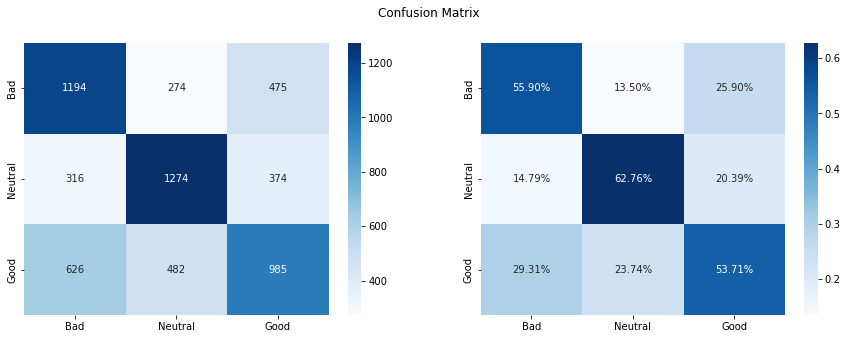

In [153]:
confusion = confusion_matrix(y_test, y_pred)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Confusion Matrix')
sns.heatmap(ax=axes[0], data=confusion, annot=True, fmt='g', cmap='Blues', xticklabels=categories, yticklabels=categories)
sns.heatmap(ax=axes[1], data=confusion/np.sum(confusion, axis=0), annot=True, fmt='.2%', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.show()

In [154]:
%%time
# fit the training dataset on the classifier
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(X_train, y_train)
# predict the labels on validation dataset
y_pred = SVM.predict(X_test)
# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score -> ",accuracy_score(y_pred, y_test)*100)

SVM Accuracy Score ->  58.699999999999996
Wall time: 1min 14s


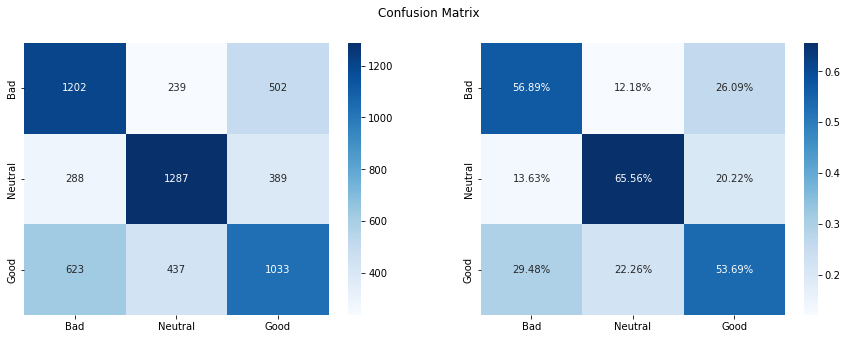

In [157]:
confusion = confusion_matrix(y_test, y_pred)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Confusion Matrix')
sns.heatmap(ax=axes[0], data=confusion, annot=True, fmt='g', cmap='Blues', xticklabels=categories, yticklabels=categories)
sns.heatmap(ax=axes[1], data=confusion/np.sum(confusion, axis=0), annot=True, fmt='.2%', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.show()

### Post model analysis

In [57]:
true_values = list(y_test)
pred_values = y_pred

df_check = pd.DataFrame(columns=['review index', 'text', 'true label', 'pred label'])
for i, j in zip(y_test.index, range(len(y_test))):
    df_check.loc[len(df_check.index)] = [i, df.loc[i, 'Text'], true_values[j], pred_values[j]] 

In [58]:
pd.set_option('display.max_colwidth', None)

In [59]:
df_check.head(5)

,review index,text,true label,pred label
0,6365,"I bought these because my brother LOVES them and they stopped selling them at our Costco. So, since they were a gift, it was important that at least look okay... they looked terrible! I understand that they were shipped, but the chocolate was cracked in places and chunks of it had stuck to the container. Ah, well... I'm sure he'll still be excited because he likes them so much, but still pretty disappointing since I paid over twice what they used to cost at Costco.",Bad,Neutral
1,2873,eating these was sort of like eating a salted air bubble. It was great for snacking because it takes a while to eat one package but they really tasted like salty air. I am not sure I really liked them at all.,Bad,Bad
2,11519,"To start with, I'll be upfront about a few things:<br /><br />A) I got this coffee free to try through the Amazon Vine program.<br /><br />B) I don't have a pod coffee maker, so I ripped open several bags and put the grounds in a normal filter, making a full 10 cup pot at a time.<br /><br />This said, I'm not in much of a position to assess the pod concept as I didn't use them this way.<br /><br />As far as the coffee itself. Its fair, but not great. Like other reviewers have mentioned its pretty weak stuff. The taste kinda reminds me of a smoother McDonalds coffee. Not bold by any means, but certainly drinkable if you're open to that kind of thing.<br /><br />I prefer a stronger flavor, so I won't be buying it again.",Neutral,Neutral
3,28330,"NOT DISAPPOINTED WITH THIS PRODUCT! I really love this cereal! I have IBD and corn is more easily digested than wheat in my case. This is far superior to plain ole' corn flakes! Thanks, Amazon, for making it available.",Good,Bad
4,8080,"I guess I should have looked around more, I was expecting them in a tub. Instead they were in 3 baggies with sticky ties and it made me feel a bit uneasy.... I was thinking: who packaged these, where were these packaged and why don't I have any product information included?<br />I don't believe the price was any better than what I could of found in a local candy store or drugstore. I've purchased more product for less money before. The Christmas tree shop in Wiliston, VT sells a 4 lb. tub for $5.99 but since I just moved to FL... my local knowledge of stores is limited.<br /><br />I bought these for a specific reason, I am attending a memorial service for a dear relative (who loved these) and I was planning on bringing them and putting them in dishes for those attending the service, instead because of the small size of them (I've seen larger ones) and because they have too much sugar on them, I will be keeping them at home and buying others somewhere else.",Bad,Neutral


In [64]:
processed_df.loc[8080, 'Text']

'guess look around expect tub instead baggi sticki tie made feel bit uneasi think packag packag product inform includ believ price better could found local candi store drugstor purchas product less money christma tree shop wiliston vt sell lb tub sinc move fl local knowledg store limit bought specif reason attend memori servic dear rel love plan ing put dish attend servic instead small size seen larger one much sugar keep home buy other somewher els'

Here we can see some examples of incorrect classifications by the model. Many of these contain positive words such as loved or great but they are referring to other past products and some even use sarcasm (which uses very positive words to describe negative experiences). 

A potential improvement for the model would be to add 2-gram combinations which would allow the model to identify "Not disappointed" as something positive instead of separating "not" and "disappointed", leading to the wrong conclusion.

In [201]:
#df_check[df_check['true label'] == df_check['pred label']]

### Comments
* I removed all 'br' (html break)

### To do 
* Do pegasus (with 2 classes)
* Add example of before preprocessing and after 